In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

import os
print(os.listdir("../input/data/"))
# Any results you write to the current directory are saved as output.

['men', 'women']


In [3]:
from fastai import *
from fastai.vision import *

In [4]:
import fastai
print("FASTAI VERSION:", fastai.__version__)


FASTAI VERSION: 1.0.51


In [5]:
import torch
print("Device Count:", torch.cuda.device_count())
print("Device Name:", torch.cuda.get_device_name(0))

Device Count: 1
Device Name: Tesla P100-PCIE-16GB


In [6]:
path = Path('../input/data/')
classes = ['men', 'women']
folders = ['men', 'women']
files = ['men.txt', 'women.txt']

# Getting images from Google Images
This section is about getting the data from Google Images. 
In this cases, that's how I got the data, but the cleansed data are stored on Kaggle.
https://www.kaggle.com/playlist/men-women-classification

1. Search a term on Google Images
2. Scroll until you have enough data
3. Open a JS console
4. Copy/Paste the link below

**Javascript to get the links of Google images in a txt file :**
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));

In [ ]:
# Download loop -- DON'T RUN THIS CELL IF YOU HAVE DOWNLOADED THE CLEANSED DATASET ON KAGGLE
for i in range(len(classes)):
    print(classes[i])
    download_path = path/folders[i]
    path.mkdir(parents=True, exist_ok=True)
    download_images(files[i], download_path, max_pics=2500)

In [ ]:
# Remove images that can't be opened
for i in classes:
    print(i)
    verify_images(path/i, delete=True) # add 'max-size=500' to resize pictures to save time and GPU memory

# Creating ImageDataBunch and training

In [9]:
bs = 64

In [10]:
# Defining the seed so I can limit the randomness in my model
np.random.seed(1337)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, ds_tfms=get_transforms(), bs=bs, size=224).normalize(imagenet_stats)

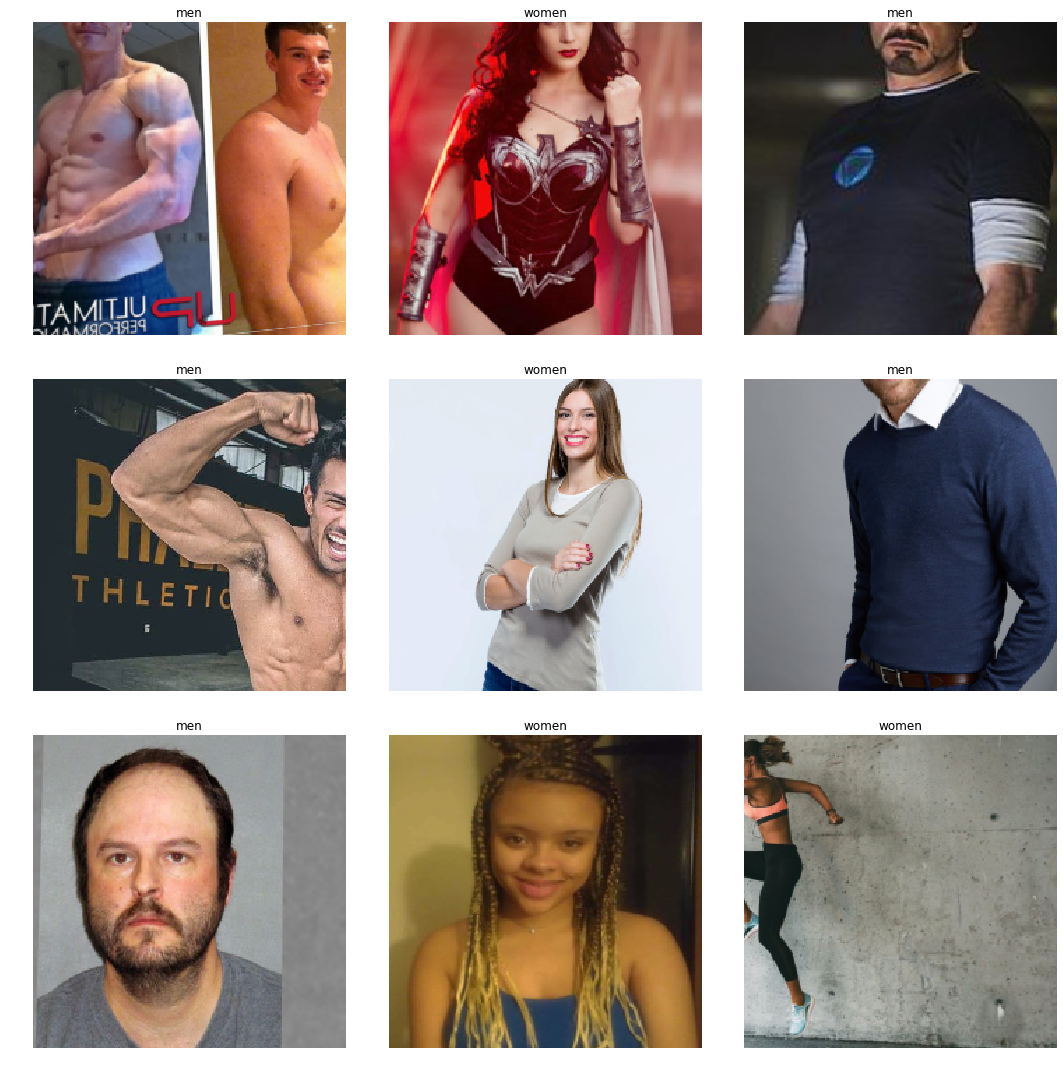

In [15]:
data.show_batch(rows=3, figsize=(15,15))

In [12]:
resnet34 = models.resnet34
resnet50 = models.resnet50
resnet101 = models.resnet101
resnet152 = models.resnet152

In [13]:
# create Convolutional Neural Network
learn = cnn_learner(data, resnet50, metrics=error_rate, model_dir="/tmp/model/")

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.torch/models/resnet50-19c8e357.pth
102502400it [00:01, 77383496.94it/s]


In [16]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.433391,0.248480,0.096096,02:26
1,0.324092,0.195588,0.079580,02:23
2,0.249998,0.169974,0.063063,02:21
3,0.205379,0.171076,0.060060,02:20


In [17]:
learn.save("stage-1")

In [32]:
learn.unfreeze()

In [33]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


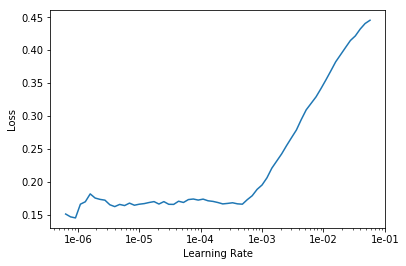

In [34]:
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(2, max_lr=1e-7)

epoch,train_loss,valid_loss,error_rate,time
0,0.162502,0.168791,0.061562,02:24
1,0.162366,0.172821,0.057057,02:20


With these settings the result should be good already.
I managed to have a 0.57 error_rate, so an accuracy of **94.3%** !

# Interpretation

In [37]:
interp = ClassificationInterpretation.from_learner(learn)

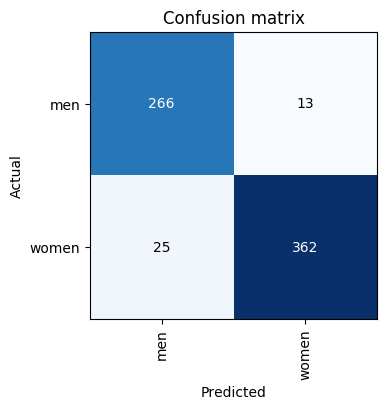

In [38]:
interp.plot_confusion_matrix(dpi=100)

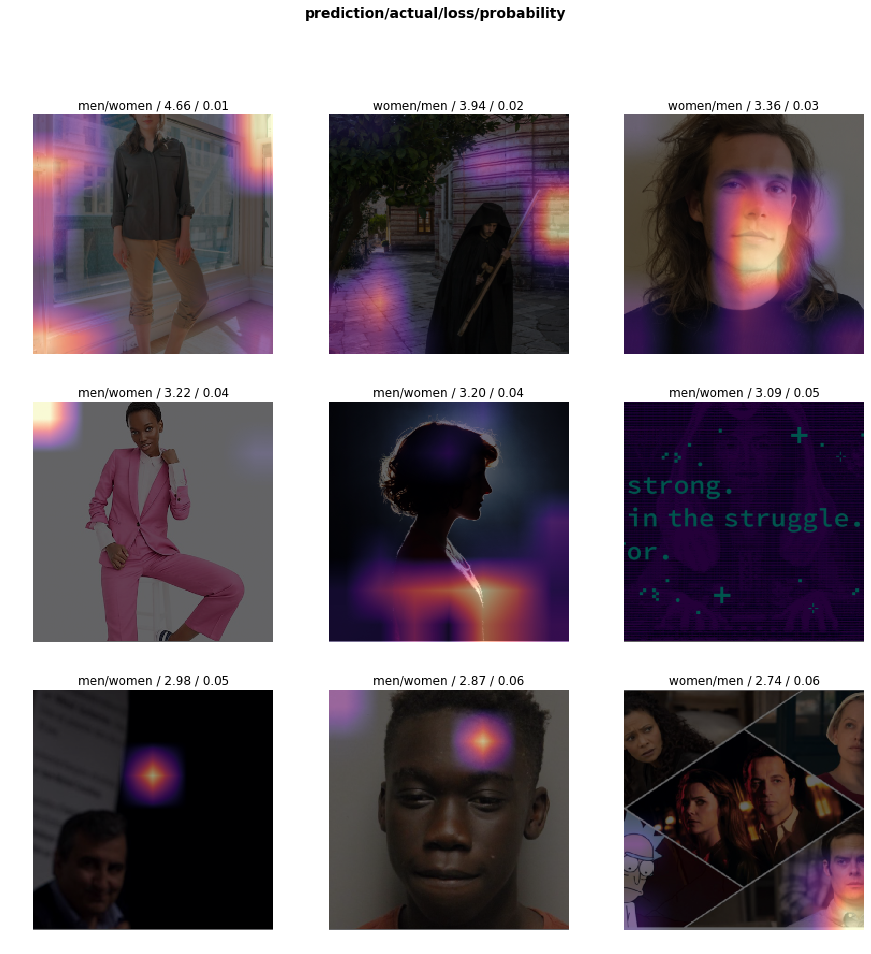

In [39]:
interp.plot_top_losses(9, figsize=(15,15))

In [ ]:
losses,idxs = interp.top_losses(15)
number = 1
for i in data.valid_ds.x.items[idxs]:
    print(number, i)
    number+=1